In [275]:
import numpy as np
import pandas as pd

df = pd.read_csv('val.csv', sep = ';')
print("Nombre de valeurs nulles par colonne :" ,df.isnull().sum())
df.fillna(0,inplace = True)
df = df.replace('Moins de 5', 0)
df['NB_VALD'] = df['NB_VALD'].astype(np.int)
grouped_data = df.groupby(['LIBELLE_ARRET','CATEGORIE_TITRE'],as_index=False).sum()
grouped_data = grouped_data.pivot(index='LIBELLE_ARRET', columns='CATEGORIE_TITRE', values='NB_VALD')
grouped_data.fillna(0,inplace = True)


Nombre de valeurs nulles par colonne : JOUR                  0
CODE_STIF_TRNS        0
CODE_STIF_RES         0
CODE_STIF_ARRET       0
LIBELLE_ARRET         0
ID_REFA_LDA        3578
CATEGORIE_TITRE       0
NB_VALD               0
dtype: int64


In [276]:
grouped_data.head(5)


CATEGORIE_TITRE,AMETHYSTE,AUTRE TITRE,FGT,IMAGINE R,NAVIGO,NON DEFINI,TST
LIBELLE_ARRET,,,,,,,
ABBESSES,15163.0,5565.0,15334.0,97578.0,404779.0,0.0,12843.0
ABLON,3981.0,381.0,8317.0,41045.0,142210.0,0.0,9152.0
ACHERES-GRAND-CORMIER,115.0,24.0,58.0,909.0,6807.0,0.0,458.0
ACHERES-VILLE,9715.0,16539.0,26569.0,132201.0,473971.0,0.0,28961.0
AEROPORT CHARLES DE GAULLE 1,8814.0,20656.0,44180.0,96622.0,628980.0,0.0,48370.0


# 20 premières stations en termes de validations :

In [63]:
grouped_data.fillna(0,inplace = True)
grouped_data['SUM'] = np.sum(grouped_data, axis = 1)

print("20 premières stations en termes de validations :", grouped_data.sort_values(by=['SUM'], ascending = False).index[:20].tolist())

20 premières stations en termes de validations : ['LA DEFENSE-GRANDE ARCHE', 'SAINT-LAZARE', 'GARE DE LYON', 'GARE DU NORD', 'MONTPARNASSE', "GARE DE L'EST", 'CHATELET-LES HALLES', 'REPUBLIQUE', 'LES HALLES', 'BIBLIOTHEQUE FRANCOIS MITTERRAND', 'AUSTERLITZ', 'CHARLES DE GAULLE ETOILE', 'NATION', 'SAINT-DENIS', 'BARBES-ROCHECHOUART', 'HAUSSMANN-SAINT-LAZARE', 'BASTILLE', 'BELLEVILLE', "PLACE D'ITALIE", 'SAINT-MICHEL NOTRE DAME']


# Illustration graphique du classement :

Populating the interactive namespace from numpy and matplotlib


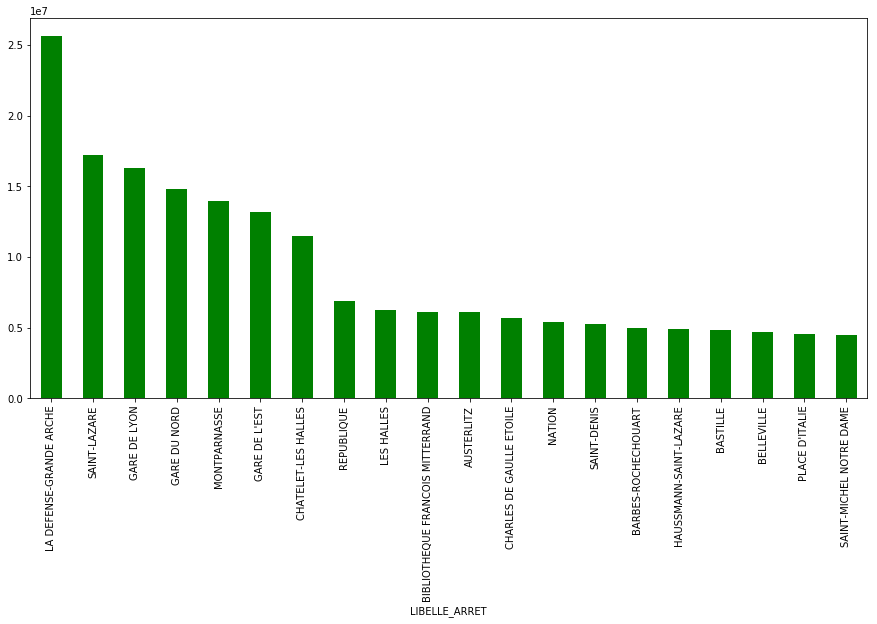

In [5]:
% pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 7.0)
grouped_data.sort_values(by=['SUM'], ascending = False)[:20].SUM.plot.bar(color="green")

# Classification des arrêts en fonction du nombre de validations par titre de transport : 
Je propose un clustering des gares en fonction de ces nombres, à l'aide de l'algorithme Kmeans. Afin de déterminer le nombre de clusters, on se référère tout d'abords à la somme des écarts au carré à l'intérieur des clusters (distortion score, défini comme la somme des écarts des observations avec le centre de leur cluster).

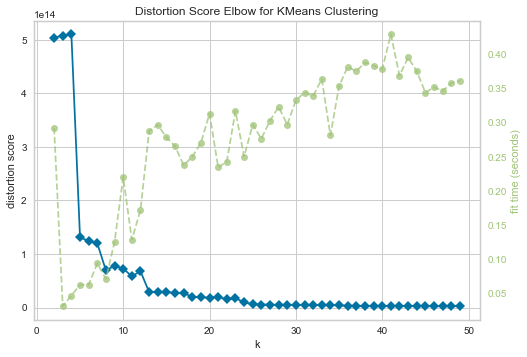

In [272]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), k=(2,50))
visualizer.fit(grouped_data) 
visualizer.poof()


Il semblerait que 12 clusters soient un compromis idéal. Afin de confirmer ce nombre, on peut utiliser la méthode Silhouette:
    une mesure de "cohésion" entre une donnée et son cluster. Une valeur proche de 1 signifie un bon matching entre une donnée 
    et son cluster, une valeur négative est informative d'un matching non-adéquat. 
    Le résultat semble assez satisfaisant dans ce cas, avec une grande majorité des observations ayant un score positif, voir supérieur à 0.5.
    
   
   

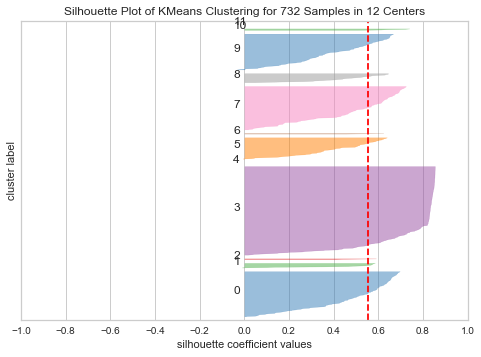

In [7]:
from yellowbrick.cluster import SilhouetteVisualizer

model =KMeans(12)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(grouped_data) 
visualizer.poof()


# Prédiction : 

Le modèle proposé est un réseau de neurones avec cellules LSTM et des ConvNN. L'idée est d'utiliser toutes les observations contenues dans les clusters des gares "BONNE NOUVELLE" et "CHAVILLE RIVE DROITE".
Par ailleurs, j'ai ajouté en caractéristiques la somme des validations, un label des jours, et trois moyenne mobiles du total de validation et de chaque type de validation (sur 14, 7 et 2 jours) afin de capter les dynamiques locales (vacances, jours fériées, weekend, etc), puis la différence entre ces moyennes mobiles (pour le total des validations) et le nombre de validation.

Fonction 'process' qui permet :
- d'extraire le labels des jours, les moyennes mobiles.
- de regrouper dans un même tableau les données des gares 
ayant le même label que 'value'

La fonction load_data qui permet d'obtenir des lignes de dimension (-1, timesteps, features), timesteps (ici = 7) étant la longueur de la série à utiliser pour prédire la série en [t+8, t+14]. Il s'agit d'une architecture de réseau de neuronnes "many to many", soit une série en entrée qui prédit une série en sortie. La valeur de timesteps peut être vue comme un hyperparamètre, et donc faire l'object d'une recherche par validation croisée par exemple. 
Par soucis de temps/ressources, je n'ai pas effectué d'optimization d'hyperparamètres (Grid ou Random search, etc) : le modèle est donc perfectible dans ses paramètres (dimension des cellules, lr, dropout, régularisations supplémentaires/weights reg, batch_size, paramètres du ConvNN).

Le modèle inclut une normalisation des batchs en sorties de layers, un dropout en régularisation, une réduction automatique du learning rate (plateau) et un early stop. Par ailleurs, les données d'entraînement sont "shufflées", afin d'apporter un peu plus de régularisation. 


(Train/Test = 0.9/0.1, la plage du 24 au 30 juin est présente dans les données test)

Bien entendu, si on inclus dans les données d'entraînement la plage du 24 au 30 juin des gares (chaville et bonne nouvelle non inclus), on obtient des prédictions plus performantes pour les gares cibles. L'idée ici est de se passer de toutes les données en fin de période.

In [103]:
#Kmeans 
from sklearn.preprocessing import StandardScaler as s

kmeans = KMeans(n_clusters=12, random_state=0).fit(grouped_data)
labels = kmeans.labels_
labels = labels.reshape(-1,1)
labels = pd.DataFrame(labels, index = grouped_data.index)


def process(data, value, labels): 
    l = []
    a = labels.loc[labels[0] == labels.loc[value][0]]

    for i in range(len(a)):
        data_ = data.loc[data['LIBELLE_ARRET'] == a.index[i]]
        data_ = data_.pivot_table(index='JOUR', columns='CATEGORIE_TITRE', values='NB_VALD')
        data_['sum'] = data_.sum(axis = 1)
        data_['rolling_mean_1'] = pd.rolling_mean(data_['sum'],window=2)
        data_['rolling_mean_2'] = pd.rolling_mean(data_['sum'],window=7)
        data_['rolling_mean_3'] = pd.rolling_mean(data_['sum'],window=14)
        data_['rolling_mean1_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=2)
        data_['rolling_mean2_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=7)
        data_['rolling_mean3_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=14)
        data_['rolling_mean1_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=2)
        data_['rolling_mean2_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=7)
        data_['rolling_mean3_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=14)
        data_['rolling_mean1_FGT'] = pd.rolling_mean(data_['FGT'],window=2)
        data_['rolling_mean2_FGT'] = pd.rolling_mean(data_['FGT'],window=7)
        data_['rolling_mean3_FGT'] = pd.rolling_mean(data_['FGT'],window=14)
        data_['rolling_mean1_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=2)
        data_['rolling_mean2_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=7)
        data_['rolling_mean3_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=14)
        data_['rolling_mean1_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=2)
        data_['rolling_mean2_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=7)
        data_['rolling_mean3_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=14)
        data_['rolling_mean1_TST'] = pd.rolling_mean(data_['TST'],window=2)
        data_['rolling_mean2_TST'] = pd.rolling_mean(data_['TST'],window=7)
        data_['rolling_mean3_TST'] = pd.rolling_mean(data_['TST'],window=14)
        data_['rolling_diff_1'] = data_['sum'] - data_['rolling_mean_1']
        data_['rolling_diff_2'] = data_['sum'] - data_['rolling_mean_2']
        data_['rolling_diff_3'] = data_['sum'] - data_['rolling_mean_3']
        data_.fillna(0,inplace = True)
        data_['my_dates'] = pd.to_datetime(data_.index)
        data_['day_of_week'] = data_['my_dates'].dt.weekday_name
        del data_['day_of_week']
        del data_['my_dates']
        l.append(data_)
        
    return l

            
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len  
    result = []

    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] 
    
    X_train = train[:len(train)-7, :] 
    y_train = train[7:, :]
    X_test = result[int(row):len(result)-7, :]
    y_test = result[int(row)+7:, :]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

t = process(df, 'CHAVILLE RIVE DROITE', labels)

x = []
x_t = []
y = []
y_t = []

for i in range(len(t)):
    if t[i].shape[1] != 31:
        i += 1
    data = load_data(t[i],7)
    x.append(data[0])
    y.append(data[1])
    x_t.append(data[2])
    y_t.append(data[3])


x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
x_t = np.concatenate(x_t, axis=0)
y_t = np.concatenate(y_t, axis=0)


#standardisation des données
sp = s().fit(x.reshape(-1,31))
x = sp.transform(x.reshape(-1,31)).reshape(-1,7,31)
x_t = sp.transform(x_t.reshape(-1,31)).reshape(-1,7,31)
y = sp.transform(y.reshape(-1,31)).reshape(-1,7,31)
y_t= sp.transform(y_t.reshape(-1,31)).reshape(-1,7,31)


In [124]:
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Convolution1D
from keras.callbacks import ReduceLROnPlateau



model = Sequential()
model.add(Convolution1D(input_shape = (7, 31),
                        nb_filter=860,
                        filter_length=5,
                        border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))                  
model.add(Convolution1D(nb_filter=580,
                        filter_length=5,
                        border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(LSTM(320, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(Dropout(0.4))    
model.add(LSTM(190, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(LSTM(90, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(Dropout(0.2))    
model.add(LSTM(31, batch_input_shape=(-1,x.shape[1],), return_sequences = True,  activation = None))

opt = Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, min_lr=0.000001, verbose=1)

model.compile(optimizer=opt, 
              loss='mean_squared_error')

model.fit(x, y, 
          nb_epoch = 150, 
          batch_size = 300, 
          verbose=2, 
          validation_data=(x_t, y_t),
          callbacks=[reduce_lr, EarlyStopping(min_delta=0.0001, patience=5)],
          shuffle=True)

Train on 17161 samples, validate on 1144 samples
Epoch 1/150
 - 19s - loss: 0.8300 - val_loss: 0.5854
Epoch 2/150
 - 5s - loss: 0.6270 - val_loss: 0.4559
Epoch 3/150
 - 5s - loss: 0.5206 - val_loss: 0.3804
Epoch 4/150
 - 5s - loss: 0.4489 - val_loss: 0.3223
Epoch 5/150
 - 5s - loss: 0.3928 - val_loss: 0.2788
Epoch 6/150
 - 5s - loss: 0.3426 - val_loss: 0.2255
Epoch 7/150
 - 5s - loss: 0.2985 - val_loss: 0.1901
Epoch 8/150
 - 5s - loss: 0.2683 - val_loss: 0.1687
Epoch 9/150
 - 5s - loss: 0.2452 - val_loss: 0.1534
Epoch 10/150
 - 5s - loss: 0.2290 - val_loss: 0.1439
Epoch 11/150
 - 5s - loss: 0.2169 - val_loss: 0.1359
Epoch 12/150
 - 5s - loss: 0.2066 - val_loss: 0.1308
Epoch 13/150
 - 5s - loss: 0.1986 - val_loss: 0.1254
Epoch 14/150
 - 5s - loss: 0.1915 - val_loss: 0.1184
Epoch 15/150
 - 5s - loss: 0.1857 - val_loss: 0.1154
Epoch 16/150
 - 5s - loss: 0.1797 - val_loss: 0.1115
Epoch 17/150
 - 5s - loss: 0.1750 - val_loss: 0.1149

Epoch 00017: ReduceLROnPlateau reducing learning rate to 

In [125]:
#récupération des données de chaville rive droite uniquement 

data_ = df.loc[df['LIBELLE_ARRET'] == 'CHAVILLE RIVE DROITE' ]
data_ = data_.pivot_table(index='JOUR', columns='CATEGORIE_TITRE', values='NB_VALD')
data_['sum'] = data_.sum(axis = 1)
data_['rolling_mean_1'] = pd.rolling_mean(data_['sum'],window=2)
data_['rolling_mean_2'] = pd.rolling_mean(data_['sum'],window=7)
data_['rolling_mean_3'] = pd.rolling_mean(data_['sum'],window=14)
data_['rolling_mean1_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=2)
data_['rolling_mean2_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=7)
data_['rolling_mean3_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=14)
data_['rolling_mean1_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=2)
data_['rolling_mean2_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=7)
data_['rolling_mean3_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=14)
data_['rolling_mean1_FGT'] = pd.rolling_mean(data_['FGT'],window=3)
data_['rolling_mean2_FGT'] = pd.rolling_mean(data_['FGT'],window=7)
data_['rolling_mean3_FGT'] = pd.rolling_mean(data_['FGT'],window=14)
data_['rolling_mean1_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=2)
data_['rolling_mean2_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=7)
data_['rolling_mean3_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=14)
data_['rolling_mean1_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=2)
data_['rolling_mean2_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=7)
data_['rolling_mean3_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=14)
data_['rolling_mean1_TST'] = pd.rolling_mean(data_['TST'],window=2)
data_['rolling_mean2_TST'] = pd.rolling_mean(data_['TST'],window=7)
data_['rolling_mean3_TST'] = pd.rolling_mean(data_['TST'],window=14)
data_['rolling_diff_1'] = data_['sum'] - data_['rolling_mean_1']
data_['rolling_diff_2'] = data_['sum'] - data_['rolling_mean_2']
data_['rolling_diff_3'] = data_['sum'] - data_['rolling_mean_3']
data_.fillna(0,inplace = True)
data_['my_dates'] = pd.to_datetime(data_.index)
data_['day_of_week'] = data_['my_dates'].dt.weekday_name
del data_['day_of_week']
del data_['my_dates']


x_ch = []
y_ch = []
data = load_data(data_,7)
x_ch = data[2]
y_ch = data[3]
x_ch = sp.transform(x_ch.reshape(-1,31)).reshape(-1,7,31)


pred = model.predict(x_ch)
pred = sp.inverse_transform(pred.reshape(-1,31)).reshape(-1,7,31)
pred = np.round(pred)

print("Prédiction du total des validations sur la plage du 24 au 30 juin à Chaville rive droite ")
print("Données test :", y_ch[-1,:,6])
print("Prediction :", pred[-1,:,6])    

Prédiction du total des validations sur la plage du 24 au 30 juin à Chaville rive droite 
Données test : [3084. 1246.  929. 2891. 3015. 2978. 3155.]
Prediction : [2688. 1095.  729. 2721. 3023. 2876. 2737.]


In [264]:
t = process(df, 'BONNE NOUVELLE', labels)
x = []
x_t = []
y = []
y_t = []

for i in range(len(t)):
    if t[i].shape[1] != 31:
        i += 1
    data = load_data(t[i],7)
    x.append(data[0])
    y.append(data[1])
    x_t.append(data[2])
    y_t.append(data[3])


x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
x_t = np.concatenate(x_t, axis=0)
y_t = np.concatenate(y_t, axis=0)


#standardisation des données
sp = s().fit(x.reshape(-1,31))
x = sp.transform(x.reshape(-1,31)).reshape(-1,7,31)
x_t = sp.transform(x_t.reshape(-1,31)).reshape(-1,7,31)
y = sp.transform(y.reshape(-1,31)).reshape(-1,7,31)
y_t= sp.transform(y_t.reshape(-1,31)).reshape(-1,7,31)

In [270]:
model = Sequential()
model.add(Convolution1D(input_shape = (7, 31),
                        nb_filter=860,
                        filter_length=5,
                        border_mode='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))                  
model.add(Convolution1D(nb_filter=580,
                        filter_length=5,
                        border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(LSTM(320, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(Dropout(0.2))    
model.add(LSTM(190, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(LSTM(90, batch_input_shape=(-1,x.shape[1],), return_sequences = True))
model.add(Dropout(0.2))    
model.add(LSTM(31, batch_input_shape=(-1,x.shape[1],), return_sequences = True,  activation = None))

opt = Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.000001, verbose=1)

model.compile(optimizer=opt, 
              loss='mean_squared_error')

model.fit(x, y, 
          nb_epoch = 150, 
          batch_size = 300, 
          verbose=2, 
          validation_data=(x_t, y_t),
          callbacks=[reduce_lr, EarlyStopping(min_delta=0.0001, patience=20)],
          shuffle=True)


Train on 9895 samples, validate on 660 samples
Epoch 1/150
 - 147s - loss: 0.8523 - val_loss: 0.6571
Epoch 2/150
 - 4s - loss: 0.7392 - val_loss: 0.5639
Epoch 3/150
 - 4s - loss: 0.6410 - val_loss: 0.4752
Epoch 4/150
 - 4s - loss: 0.5554 - val_loss: 0.4101
Epoch 5/150
 - 5s - loss: 0.4946 - val_loss: 0.3619
Epoch 6/150
 - 4s - loss: 0.4443 - val_loss: 0.3173
Epoch 7/150
 - 4s - loss: 0.3959 - val_loss: 0.2719
Epoch 8/150
 - 4s - loss: 0.3503 - val_loss: 0.2343
Epoch 9/150
 - 4s - loss: 0.3127 - val_loss: 0.2013
Epoch 10/150
 - 4s - loss: 0.2836 - val_loss: 0.1836
Epoch 11/150
 - 4s - loss: 0.2601 - val_loss: 0.1626
Epoch 12/150
 - 4s - loss: 0.2436 - val_loss: 0.1569
Epoch 13/150
 - 4s - loss: 0.2296 - val_loss: 0.1504
Epoch 14/150
 - 4s - loss: 0.2173 - val_loss: 0.1346
Epoch 15/150
 - 4s - loss: 0.2084 - val_loss: 0.1366
Epoch 16/150
 - 4s - loss: 0.1994 - val_loss: 0.1213
Epoch 17/150
 - 4s - loss: 0.1918 - val_loss: 0.1199
Epoch 18/150
 - 4s - loss: 0.1855 - val_loss: 0.1217
Epoch 

In [271]:
#récupération des données de Bonne nouvelle uniquement 

data_ = df.loc[df['LIBELLE_ARRET'] == 'BONNE NOUVELLE' ]
data_ = data_.pivot_table(index='JOUR', columns='CATEGORIE_TITRE', values='NB_VALD')
data_['sum'] = data_.sum(axis = 1)
data_['rolling_mean_1'] = pd.rolling_mean(data_['sum'],window=2)
data_['rolling_mean_2'] = pd.rolling_mean(data_['sum'],window=7)
data_['rolling_mean_3'] = pd.rolling_mean(data_['sum'],window=14)
data_['rolling_mean1_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=2)
data_['rolling_mean2_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=7)
data_['rolling_mean3_AMETHYSTE'] = pd.rolling_mean(data_['AMETHYSTE'],window=14)
data_['rolling_mean1_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=2)
data_['rolling_mean2_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=7)
data_['rolling_mean3_AUTRE TITRE'] = pd.rolling_mean(data_['AUTRE TITRE'],window=14)
data_['rolling_mean1_FGT'] = pd.rolling_mean(data_['FGT'],window=3)
data_['rolling_mean2_FGT'] = pd.rolling_mean(data_['FGT'],window=7)
data_['rolling_mean3_FGT'] = pd.rolling_mean(data_['FGT'],window=14)
data_['rolling_mean1_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=2)
data_['rolling_mean2_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=7)
data_['rolling_mean3_IMAGINE R'] = pd.rolling_mean(data_['IMAGINE R'],window=14)
data_['rolling_mean1_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=2)
data_['rolling_mean2_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=7)
data_['rolling_mean3_NAVIGO'] = pd.rolling_mean(data_['NAVIGO'],window=14)
data_['rolling_mean1_TST'] = pd.rolling_mean(data_['TST'],window=2)
data_['rolling_mean2_TST'] = pd.rolling_mean(data_['TST'],window=7)
data_['rolling_mean3_TST'] = pd.rolling_mean(data_['TST'],window=14)
data_['rolling_diff_1'] = data_['sum'] - data_['rolling_mean_1']
data_['rolling_diff_2'] = data_['sum'] - data_['rolling_mean_2']
data_['rolling_diff_3'] = data_['sum'] - data_['rolling_mean_3']
data_.fillna(0,inplace = True)
data_['my_dates'] = pd.to_datetime(data_.index)
data_['day_of_week'] = data_['my_dates'].dt.weekday_name
del data_['day_of_week']
del data_['my_dates']


x_bn = []
y_bn = []
data = load_data(data_,7)
x_bn = data[2]
y_bn = data[3]
x_bn = sp.transform(x_bn.reshape(-1,31)).reshape(-1,7,31)


pred = model.predict(x_bn)
pred = sp.inverse_transform(pred.reshape(-1,31)).reshape(-1,7,31)
pred = np.round(pred)

print("Prédiction du total des validations sur la plage du 24 au 30 juin à Bonne Nouvelle ")
print("Données test :", y_bn[-1,:,6])
print("Prediction :", pred[-1,:,6])    

Prédiction du total des validations sur la plage du 24 au 30 juin à Bonne Nouvelle 
Données test : [11976. 11394.  3879. 11594. 13622. 13488. 13393.]
Prediction : [10661.  5163.  3518. 12042. 12953. 13053. 12702.]
